# Advanced Transfer Learning with ResNet18 on CIFAR-10

This notebook demonstrates advanced transfer learning using a pretrained ResNet18 model on the CIFAR-10 dataset. We'll replace the classifier head and fine-tune the model for better performance.

## 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time
from sklearn.model_selection import train_test_split
import cv2

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Load and Preprocess CIFAR-10 Dataset + Data Augmentation

CIFAR-10 consists of 60,000 32x32 color images in 10 classes. We'll apply extensive data augmentation including random cropping, flipping, rotation, color jittering, affine transformations, perspective distortion, and random erasing to improve model generalization and robustness.

In [2]:
# Data transforms for training and validation with enhanced augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),  # First resize to larger size 256x256 (because now we can crop out image)
        transforms.RandomCrop(224),  # Random crop to 224x224
        transforms.RandomHorizontalFlip(),  # Horizontal flip
        transforms.RandomVerticalFlip(p=0.1),  # Occasional vertical flip
        transforms.RandomRotation(15),  # Random rotation up to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color adjustments
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Translation and scaling
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective distortion
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))  # Random erasing (cutout)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize smaller images to 256x256 to prepare for center cropping
        transforms.CenterCrop(224),  # Crop the center 224x224 region to match ResNet input size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load CIFAR-10 dataset
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train'])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['val'])

# For Stratified K-Fold tuning, keep full_train_dataset
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Classes: {class_names}")

Full training dataset size: 50000
Test dataset size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. Load Pretrained ResNet18 Model

We'll load the pretrained ResNet18 model from torchvision. Since CIFAR-10 images are 32x32 and ResNet expects 224x224, we've already resized them in the transforms.

In [3]:
# Load pretrained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Print model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4. Set Up Training Components

Define the loss function, optimizer, and move the model to the appropriate device.

In [4]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20, patience=5):
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}')

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
        
    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

## 5. Random Search Hyperparameter Tuning for Custom Classifier

We'll perform **random search** hyperparameter tuning to find the optimal classifier architecture. Random search is more efficient than grid search and often finds better hyperparameters by exploring the search space more effectively.

**Random search advantages:**
- Tests 10 random combinations instead of all possible combinations (much faster)
- More likely to find good hyperparameters in high-dimensional spaces
- Can explore continuous ranges more effectively

Each trial uses **early stopping with patience=3** and **GPU acceleration** for maximum efficiency.

In [5]:
# Random search hyperparameter tuning for the custom classifier with early stopping

def create_classifier(num_ftrs, hidden_dims, dropout_rates, device):
    
    layers = []
    in_features = num_ftrs

    for i, out_features in enumerate(hidden_dims):
        layers.append(nn.Linear(in_features, out_features).to(device))
        layers.append(nn.ReLU())
        if i < len(dropout_rates):
            layers.append(nn.Dropout(dropout_rates[i]))
        in_features = out_features

    layers.append(nn.Linear(in_features, 10).to(device))  # 10 classes for CIFAR-10
    return nn.Sequential(*layers)

def tune_classifier_hyperparameters(model, full_train_dataset, num_trials=10, max_epochs=5):
  

    num_ftrs = model.fc.in_features

    # Define hyperparameter search spaces for random sampling
    hidden_dims_options = [
        [512, 256],        # 2 hidden layers medium
        [1024, 512, 256],  # 3 hidden layers large
        [256, 128],        # 2 hidden layers small

    ]

    dropout_options = [
        [0.3, 0.2],        # Lower dropout
        [0.5, 0.3],        # Medium dropout
    
        [0.3, 0.2, 0.1],   # For 3-layer networks
        
    ]

    lr_options = [1e-4, 1e-3]  # learning rate options
    weight_decay_options = [0,1e-4,1e-3]  # weight decay options

    best_accuracy = 0.0
    best_params = {}
    best_model_state = None

    # Get labels for stratification
    labels = [label for _, label in full_train_dataset]

    print(f"Starting random search with {num_trials} trials using 80-20 train-validation split...")

    for trial in range(num_trials):
        # Randomly sample hyperparameters
        hidden_dims = random.choice(hidden_dims_options)

        # Find compatible dropout options (same length as hidden_dims)
        compatible_dropouts = [d for d in dropout_options if len(d) == len(hidden_dims)]
        if not compatible_dropouts:
            # Fallback to generate compatible dropout
            dropout_rates = [np.random.uniform(0.1, 0.5) for _ in hidden_dims]
        else:
            dropout_rates = random.choice(compatible_dropouts)

        lr = random.choice(lr_options)
        wd = random.choice(weight_decay_options)

        print(f"\nTrial {trial+1}/{num_trials}")
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout_rates}, LR: {lr}, WD: {wd}")

        # 80-20 train-validation split
        train_idx, val_idx = train_test_split(np.arange(len(full_train_dataset)), test_size=0.2, stratify=labels, random_state=42)

        # Create subsets for this split
        train_subset = Subset(full_train_dataset, train_idx)
        val_subset = Subset(full_train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

        # Create model for this trial
        temp_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
        temp_model.fc = create_classifier(num_ftrs, hidden_dims, dropout_rates, device)

        # Freeze all layers except classifier
        for param in temp_model.parameters():
            param.requires_grad = False
        for param in temp_model.fc.parameters():
            param.requires_grad = True

        # Setup optimizer and scheduler
        optimizer = optim.AdamW(temp_model.fc.parameters(), lr=lr, weight_decay=wd)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Training with early stopping for this trial
        temp_model, best_acc = train_model(temp_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=max_epochs, patience=3)

        # Use the best validation accuracy for this trial
        trial_accuracy = best_acc * 100  # Convert to percentage
        print(f"Validation Accuracy: {trial_accuracy:.2f}%")

        if trial_accuracy > best_accuracy:
            best_accuracy = trial_accuracy
            best_params = {
                'hidden_dims': hidden_dims,
                'dropout_rates': dropout_rates,
                'lr': lr,
                'weight_decay': wd
            }
            # Save the model state
            best_model_state = temp_model.state_dict().copy()

    print(f"\nBest hyperparameters found:")
    print(f"Hidden dimensions: {best_params['hidden_dims']}")
    print(f"Dropout rates: {best_params['dropout_rates']}")
    print(f"Learning rate: {best_params['lr']}")
    print(f"Weight decay: {best_params['weight_decay']}")
    print(f"Best validation accuracy: {best_accuracy:.2f}%")

    return best_params, best_accuracy, best_model_state

# Perform hyperparameter tuning with random search using 80-20 train-validation split
print("Starting random search hyperparameter tuning for the classifier...")

best_params, best_accuracy, best_model_state = tune_classifier_hyperparameters(
    models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1), full_train_dataset, num_trials=10, max_epochs=5
)

# Create the final model with best hyperparameters
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = create_classifier(num_ftrs, best_params['hidden_dims'], best_params['dropout_rates'], device)
model.load_state_dict(best_model_state)
model = model.to(device)

print(f"\nFinal model architecture: {model.fc}")

Starting random search hyperparameter tuning for the classifier...
Starting random search with 10 trials using 80-20 train-validation split...

Trial 1/10
Hidden dims: [256, 128], Dropout: [0.5, 0.3], LR: 0.001, WD: 0.001
Epoch 0/4
----------
Train Loss: 1.8292 Acc: 0.3762 | Val Acc: 0.5088
Epoch 1/4
----------
Train Loss: 1.6527 Acc: 0.4758 | Val Acc: 0.5383
Epoch 2/4
----------
Train Loss: 1.6015 Acc: 0.5066 | Val Acc: 0.5506
Epoch 3/4
----------
Train Loss: 1.5685 Acc: 0.5246 | Val Acc: 0.5665
Epoch 4/4
----------
Train Loss: 1.5519 Acc: 0.5320 | Val Acc: 0.5690
Training complete in 2m 44s
Best val Acc: 0.5690
Validation Accuracy: 56.90%

Trial 2/10
Hidden dims: [512, 256], Dropout: [0.5, 0.3], LR: 0.001, WD: 0.001
Epoch 0/4
----------
Train Loss: 1.7583 Acc: 0.4161 | Val Acc: 0.5205
Epoch 1/4
----------
Train Loss: 1.6121 Acc: 0.4951 | Val Acc: 0.5459
Epoch 2/4
----------
Train Loss: 1.5704 Acc: 0.5208 | Val Acc: 0.5510
Epoch 3/4
----------
Train Loss: 1.5310 Acc: 0.5413 | Val Acc:

In [6]:
# Split full_train_dataset into train and validation
labels = [label for _, label in full_train_dataset]
train_idx, val_idx = train_test_split(np.arange(len(full_train_dataset)), test_size=0.2, stratify=labels, random_state=42)

train_subset = Subset(full_train_dataset, train_idx)
val_subset = Subset(full_train_dataset, val_idx)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

## 6. Freeze Model Layers

We'll freeze all the convolutional layers to retain the pretrained features and only train the new classifier head initially.

In [7]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.fc.parameters():
    param.requires_grad = True

# Verify which parameters are trainable
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: ['fc.0.weight', 'fc.0.bias', 'fc.3.weight', 'fc.3.bias', 'fc.6.weight', 'fc.6.bias']


## 7. Train the Classifier Head

Train only the new classifier head while keeping the pretrained layers frozen.

In [10]:
# Train the classifier head
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.fc.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

model, _ = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20, patience=5)

Epoch 0/19
----------
Train Loss: 1.5105 Acc: 0.5463 | Val Acc: 0.5667
Epoch 1/19
----------
Train Loss: 1.5038 Acc: 0.5498 | Val Acc: 0.5739
Epoch 2/19
----------
Train Loss: 1.4945 Acc: 0.5551 | Val Acc: 0.5678
Epoch 3/19
----------
Train Loss: 1.4873 Acc: 0.5579 | Val Acc: 0.5824
Epoch 4/19
----------
Train Loss: 1.4821 Acc: 0.5591 | Val Acc: 0.5744
Epoch 5/19
----------
Train Loss: 1.4681 Acc: 0.5634 | Val Acc: 0.5863
Epoch 6/19
----------
Train Loss: 1.4633 Acc: 0.5701 | Val Acc: 0.5906
Epoch 7/19
----------
Train Loss: 1.4574 Acc: 0.5711 | Val Acc: 0.5903
Epoch 8/19
----------
Train Loss: 1.4493 Acc: 0.5740 | Val Acc: 0.5890
Epoch 9/19
----------
Train Loss: 1.4446 Acc: 0.5760 | Val Acc: 0.5949
Epoch 10/19
----------
Train Loss: 1.4345 Acc: 0.5832 | Val Acc: 0.5856
Epoch 11/19
----------
Train Loss: 1.4287 Acc: 0.5824 | Val Acc: 0.6037
Epoch 12/19
----------
Train Loss: 1.4169 Acc: 0.5908 | Val Acc: 0.6068
Epoch 13/19
----------
Train Loss: 1.4159 Acc: 0.5917 | Val Acc: 0.6041
Ep

## 8 Fine-Tune the Entire Model

Now that the classifier is trained, we'll unfreeze all layers of the ResNet backbone and fine-tune the entire model with a lower learning rate to adapt the pretrained features to CIFAR-10.

In [11]:
# Unfreeze all layers for full fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Use AdamW with lower learning rate for fine-tuning
fine_tune_optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

fine_tune_scheduler = optim.lr_scheduler.CosineAnnealingLR(fine_tune_optimizer, T_max=20)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Fine-tune for more epochs
model, _ = train_model(model, criterion, fine_tune_optimizer, fine_tune_scheduler, train_loader, val_loader, num_epochs=20, patience=10)

Epoch 0/19
----------
Train Loss: 1.1124 Acc: 0.7386 | Val Acc: 0.7977
Epoch 1/19
----------
Train Loss: 0.9509 Acc: 0.8177 | Val Acc: 0.8265
Epoch 2/19
----------
Train Loss: 0.8882 Acc: 0.8433 | Val Acc: 0.8467
Epoch 3/19
----------
Train Loss: 0.8434 Acc: 0.8629 | Val Acc: 0.8560
Epoch 4/19
----------
Train Loss: 0.8180 Acc: 0.8748 | Val Acc: 0.8586
Epoch 5/19
----------
Train Loss: 0.7969 Acc: 0.8826 | Val Acc: 0.8690
Epoch 6/19
----------
Train Loss: 0.7775 Acc: 0.8921 | Val Acc: 0.8797
Epoch 7/19
----------
Train Loss: 0.7590 Acc: 0.8995 | Val Acc: 0.8818
Epoch 8/19
----------
Train Loss: 0.7404 Acc: 0.9074 | Val Acc: 0.8824
Epoch 9/19
----------
Train Loss: 0.7283 Acc: 0.9138 | Val Acc: 0.8938
Epoch 10/19
----------
Train Loss: 0.7139 Acc: 0.9198 | Val Acc: 0.8905
Epoch 11/19
----------
Train Loss: 0.7045 Acc: 0.9224 | Val Acc: 0.8958
Epoch 12/19
----------
Train Loss: 0.6957 Acc: 0.9280 | Val Acc: 0.9030
Epoch 13/19
----------
Train Loss: 0.6876 Acc: 0.9311 | Val Acc: 0.9029
Ep

## 9. Evaluate the Model

Evaluate the fine-tuned model on the test set and compute final metrics.

Test Accuracy: 0.9576
Model saved successfully!


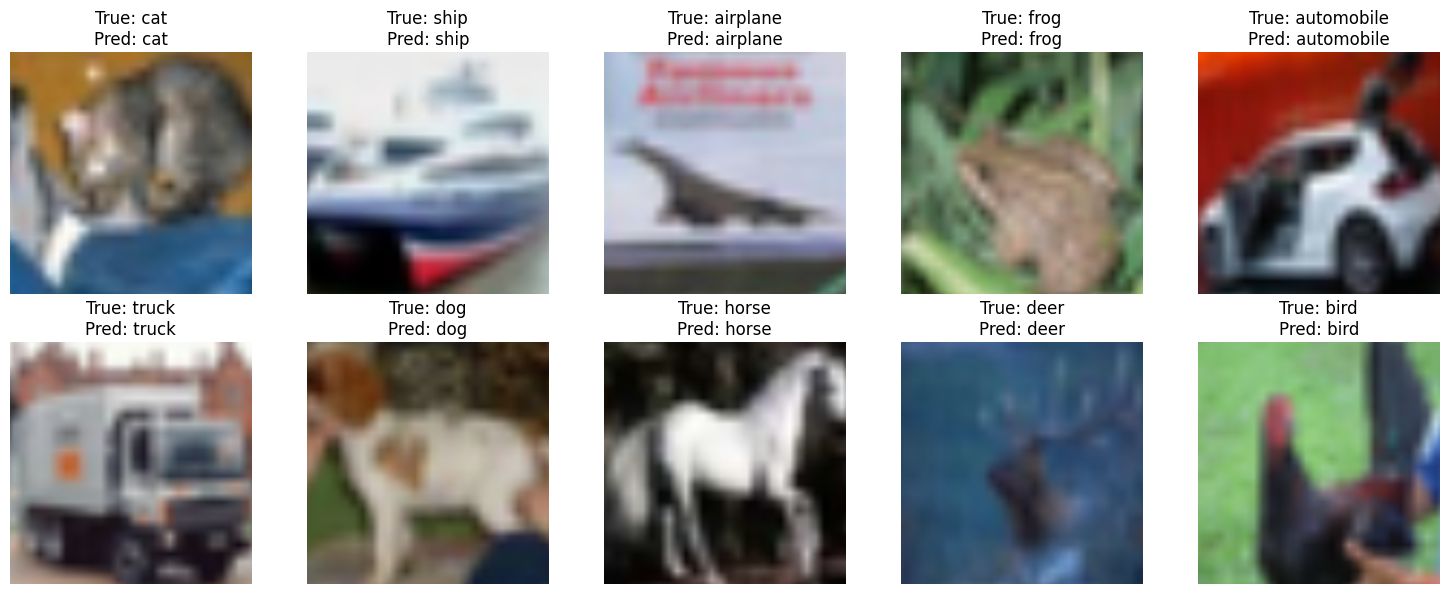

In [12]:
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item()

# Evaluate on test set
test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'resnet18_cifar10_transfer_learning.pth')
print("Model saved successfully!")

# Visualize predictions on one image per class
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Find one image per class
class_indices = {}
for idx, (img, label) in enumerate(test_dataset):
    if label not in class_indices:
        class_indices[label] = idx
    if len(class_indices) == 10:
        break

for i, (class_idx, img_idx) in enumerate(class_indices.items()):
    img, true_label = test_dataset[img_idx]
    img_tensor = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        _, pred_label = torch.max(output, 1)
        pred_label = pred_label.item()
    
    # Denormalize for display
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    
    axes[i].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 10. Gradient Flow Visualization

Visualize the gradient flow through the network to check for vanishing or exploding gradients. This helps understand how gradients propagate during backpropagation.

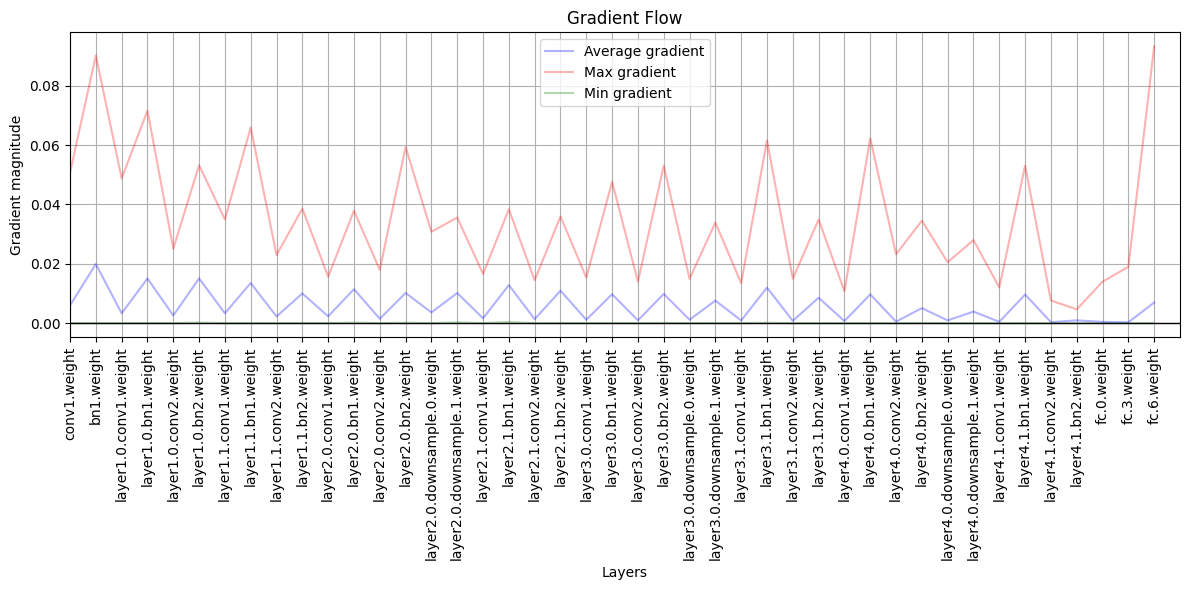

In [13]:
def plot_grad_flow(named_parameters):
   
    ave_grads = []
    max_grads = []
    min_grads = []
    layers = []

    # Iterate through model parameters to collect gradients
    for n, p in named_parameters:
        if p.requires_grad and p.grad is not None and "bias" not in n:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
            min_grads.append(p.grad.abs().min().cpu())

    plt.figure(figsize=(12, 6))
    plt.plot(ave_grads, alpha=0.3, color="b", label="Average gradient") # Blue line for average gradients
    plt.plot(max_grads, alpha=0.3, color="r", label="Max gradient") # Red line for max gradients
    plt.plot(min_grads, alpha=0.3, color="g", label="Min gradient") # Green line for min gradients
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("Gradient magnitude")
    plt.title("Gradient Flow")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# To visualize gradient flow, we need to perform a forward and backward pass
# Let's take a small batch from the test set
model.eval()
inputs, labels = next(iter(test_loader))
inputs = inputs[:4].to(device)  # Take first 4 images
labels = labels[:4].to(device)

# Define criterion (same as used in training)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Forward pass
outputs = model(inputs)
loss = criterion(outputs, labels)

# Backward pass to compute gradients
loss.backward()

# Plot gradient flow
plot_grad_flow(model.named_parameters())

## 11. Grad-CAM Visualization

Grad-CAM (Gradient-weighted Class Activation Mapping) visualizes which parts of the input image were most important for the model's prediction. This helps understand what the model is focusing on.

/tmp/ipykernel_8962/4050754157.py:126: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


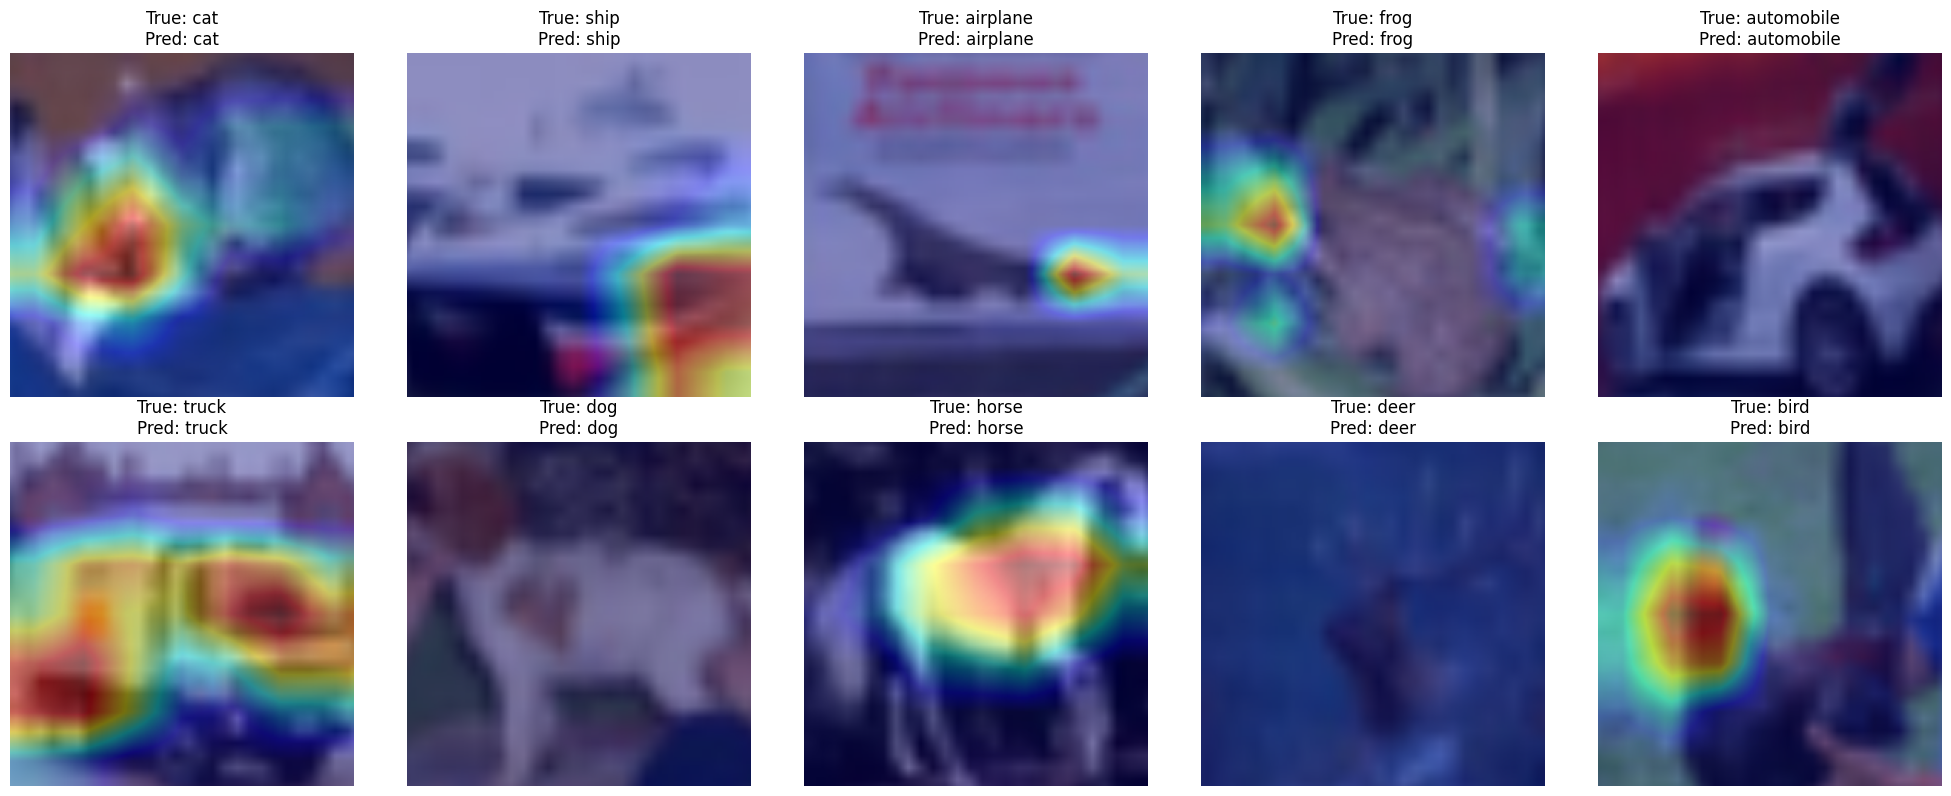

In [17]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None

        # Hook to get gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook to get feature maps
        def forward_hook(module, input, output):
            self.feature_maps = output

        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

# Generate Grad-CAM
    def generate_cam(self, input_image, target_class=None):

        # Forward pass
        self.model.eval()
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for target class
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Get weights from gradients
        weights = torch.mean(self.gradients, dim=[0, 2, 3])

        # Generate CAM
        cam = torch.zeros(self.feature_maps.shape[2:], dtype=torch.float32).to(self.feature_maps.device)
        for i, w in enumerate(weights):
            cam += w * self.feature_maps[0, i, :, :]

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.detach().cpu().numpy(), target_class

# Function to display Grad-CAM results
def show_gradcam(image, mask, predicted_class, true_class, class_names):

    # Convert to numpy
    image = image.permute(1, 2, 0).cpu().numpy()

    # Denormalize
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    # Resize mask to image size
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    mask = np.uint8(255 * mask)

    # Apply colormap
    heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay
    superimposed_img = heatmap * 0.4 + image * 255
    superimposed_img = np.uint8(superimposed_img)

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(image)
    ax1.set_title(f'Original Image\nTrue: {class_names[true_class]}')
    ax1.axis('off')

    ax2.imshow(mask, cmap='jet')
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')

    ax3.imshow(superimposed_img)
    ax3.set_title(f'Overlay\nPredicted: {class_names[predicted_class]}')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Set up Grad-CAM for ResNet18 (using the last conv layer)
target_layer = model.layer4[1].conv2  # Last convolutional layer in ResNet18
grad_cam = GradCAM(model, target_layer)

# Visualize Grad-CAM for a few test images
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

# Find one image per class
class_indices = {}
for idx, (img, label) in enumerate(test_dataset):
    if label not in class_indices:
        class_indices[label] = idx
    if len(class_indices) == 10:
        break

# Generate and plot Grad-CAM for each image
for i, (class_idx, img_idx) in enumerate(class_indices.items()):
    img, true_label = test_dataset[img_idx]
    img = img.unsqueeze(0).to(device)

    # Generate Grad-CAM
    cam, pred_class = grad_cam.generate_cam(img)

    # Denormalize for display
    display_img = img.squeeze(0).cpu()
    display_img = display_img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    display_img = torch.clamp(display_img, 0, 1)

    # Resize CAM to image size
    cam_resized = cv2.resize(cam, (display_img.shape[2], display_img.shape[1]))

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    # Overlay
    overlay = 0.4 * heatmap + 0.6 * display_img.permute(1, 2, 0).numpy()

    axes[i].imshow(overlay)
    axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_class]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()